In [5]:
import math
import random

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, BatchNormalization, Dense, Lambda, Conv2D, ReLU, Concatenate, \
    Dropout, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import Sequence
from tensorflow.python.keras.layers import MaxPooling2D

USE_ALL_ANCHORS = False
NUMBER_OF_ANCHORS = 50
FORGERY_CLASSES_PER_REFERENCE = 9
FORGERIES_PER_CLASS = 50
EMBEDDING_SIZE = 64
MARGIN = 0.1


def extract_classes(images, labels):
    classes = dict()
    for i in range(len(labels)):
        label = labels[i]
        if label not in classes:
            classes[label] = []
        classes[label].append(images[i])
    return classes


def shuffle_triplets(triplets):
    anchors, positives, negatives = triplets
    indices = list(range(len(anchors)))
    random.shuffle(indices)

    shuffled_anchors = [anchors[indices[i]]
                        for i in range(len(anchors))]
    shuffled_positives = [positives[indices[i]]
                          for i in range(len(anchors))]
    shuffled_true_negatives = [negatives[indices[i]]
                               for i in range(len(anchors))]

    return shuffled_anchors, shuffled_positives, shuffled_true_negatives


class DataGenerator(Sequence):
    def __init__(self,
                 image_classes,
                 triplets,
                 batch_size,
                 count):
        self.batch_size = batch_size
        self.count = count
        self.image_classes = image_classes
        self.anchors, self.positives, self.negatives = shuffle_triplets(triplets)
        self.true_output = np.array([[0] for _ in range(batch_size)])

    def __len__(self):
        return math.ceil(self.count / self.batch_size)

    def __getitem__(self, index):
        anchors, positives, negatives = [], [], []
        for i in range(index * self.batch_size, min((index + 1) * self.batch_size, len(self.anchors))):
            anchor_pair = self.anchors[i]
            positive_pair = self.positives[i]
            negative_pair = self.negatives[i]
            anchors.append(self.image_classes[anchor_pair[0]][anchor_pair[1]])
            positives.append(self.image_classes[positive_pair[0]][positive_pair[1]])
            negatives.append(self.image_classes[negative_pair[0]][negative_pair[1]])

        if len(anchors) == 0:
            return self.__getitem__(0)

        true_output = self.true_output
        if len(anchors) != self.batch_size:
            true_output = np.array([[0] for _ in range(len(anchors))])

        return [np.array(anchors),
                np.array(positives),
                np.array(negatives)], true_output

    def on_epoch_end(self):
        self.anchors, self.positives, self.negatives = shuffle_triplets([self.anchors, self.positives, self.negatives])


class MinimumRecurrenceRateRandomSamplerWithReplacement:
    def __init__(self, array) -> None:
        self.array = array
        self.left_choices = array.copy()

    def next(self):
        if len(self.left_choices) == 0:
            self.left_choices = self.array.copy()
        i = random.randint(0, len(self.left_choices) - 1)
        return self.left_choices.pop(i)


def generate_triplets(classes,
                      use_all_anchors=USE_ALL_ANCHORS,
                      number_of_anchors=NUMBER_OF_ANCHORS,
                      forgery_classes_per_reference=FORGERY_CLASSES_PER_REFERENCE,
                      forgeries_per_class=FORGERIES_PER_CLASS):
    keys = [*classes]
    number_of_classes = len(keys)

    anchors = []
    positives = []
    negatives = []

    for c in range(number_of_classes):
        key = keys[c]
        keys_except_key = [k for k in keys if k != key]
        if use_all_anchors:
            number_of_anchors = len(classes[key])
        else:
            number_of_anchors = min(number_of_anchors, len(classes[key]))
        anchor_indices_sampler = MinimumRecurrenceRateRandomSamplerWithReplacement(list(range(len(classes[key]))))

        for r in range(number_of_anchors):
            anchor_index = anchor_indices_sampler.next()
            reference = [key, anchor_index]
            genuine_indices = list(range(len(classes[key])))
            genuine_indices.pop(anchor_index)
            genuine_indices_sampler = MinimumRecurrenceRateRandomSamplerWithReplacement(genuine_indices)
            forgery_keys = random.sample(keys_except_key, min(forgery_classes_per_reference, len(keys_except_key)))

            for forgery_key in forgery_keys:
                forgery_class = classes[forgery_key]
                forgery_indices_sampler = MinimumRecurrenceRateRandomSamplerWithReplacement(
                    list(range(len(forgery_class))))
                forgeries = [[forgery_key, forgery_indices_sampler.next()]
                             for _ in range(min(forgeries_per_class, len(forgery_class)))]

                anchors.extend([reference] * len(forgeries))
                positives.extend([[key, genuine_indices_sampler.next()]
                                  for _ in range(len(forgeries))])
                negatives.extend(forgeries)

    return anchors, positives, negatives


def stacked_conv(filters, model):
    model = Conv2D(filters=filters,
                   kernel_size=(3, 3),
                   padding='same',
                   use_bias=False,
                   kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ReLU(negative_slope=0.05)(model)
    model = Conv2D(filters=filters,
                   kernel_size=(3, 3),
                   padding='same',
                   use_bias=False,
                   kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    return ReLU(negative_slope=0.05)(model)


def conv_block(filters, model):
    model = stacked_conv(filters, model)
    return MaxPooling2D(pool_size=(2, 2))(model)


def embedding_network(input_shape=(28, 28, 1)):
    input_layer = Input(shape=input_shape)
    embedding = Dropout(0.05)(input_layer)

    embedding = conv_block(16, embedding)
    embedding = Dropout(0.2)(embedding)
    embedding = conv_block(32, embedding)
    embedding = Dropout(0.2)(embedding)
    embedding = conv_block(64, embedding)
    embedding = Dropout(0.2)(embedding)

    embedding = Conv2D(filters=64,
                       kernel_size=(1, 1),
                       padding='same',
                       use_bias=False,
                       kernel_initializer='he_normal')(embedding)
    embedding = BatchNormalization()(embedding)
    embedding = ReLU(negative_slope=0.05)(embedding)
    embedding = Conv2D(filters=64,
                       kernel_size=(1, 1),
                       padding='same',
                       use_bias=False,
                       kernel_initializer='he_normal')(embedding)
    embedding = BatchNormalization()(embedding)
    embedding = ReLU(negative_slope=0.05)(embedding)
    embedding = Flatten()(embedding)
    embedding = Dropout(0.2)(embedding)

    embedding = Dense(units=EMBEDDING_SIZE,
                      kernel_initializer='he_normal',
                      use_bias=False)(embedding)
    embedding = BatchNormalization()(embedding)
    embedding = ReLU(negative_slope=0.05)(embedding)
    embedding = Dropout(0.2)(embedding)

    embedding = Dense(units=EMBEDDING_SIZE,
                      kernel_initializer='he_normal')(embedding)
    embedding = ReLU()(embedding)

    embedding = Lambda(function=lambda x: tf.math.l2_normalize(x, axis=-1))(embedding)
    return Model(inputs=input_layer, outputs=embedding)


def triplet_wrapped_model(input_shape=(28, 28, 1),
                          embedding_net=embedding_network()):
    anchor = Input(input_shape)
    positive = Input(input_shape)
    negative = Input(input_shape)

    anchor_embedding = embedding_net(anchor)
    positive_embedding = embedding_net(positive)
    negative_embedding = embedding_net(negative)

    merged_vector = Concatenate(axis=-1)([anchor_embedding,
                                          positive_embedding,
                                          negative_embedding])

    return Model(inputs=[anchor, positive, negative], outputs=merged_vector)


def squared_euclidean_distance(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=-1)


def triplet_loss(_, y_pred, margin=MARGIN):
    total_length = y_pred.shape.as_list()[-1]

    anchor = y_pred[:, 0:int(total_length * 1 / 3)]
    positive = y_pred[:, int(total_length * 1 / 3):int(total_length * 2 / 3)]
    negative = y_pred[:, int(total_length * 2 / 3):int(total_length * 3 / 3)]

    positive_dist = squared_euclidean_distance(anchor, positive)
    negative_dist = squared_euclidean_distance(anchor, negative)

    return tf.reduce_mean(tf.maximum(positive_dist - negative_dist + margin, 0.0))


def accuracy(_, y_pred, margin=MARGIN):
    anchor = y_pred[:, 0:EMBEDDING_SIZE]
    positive = y_pred[:, EMBEDDING_SIZE: EMBEDDING_SIZE * 2]
    negative = y_pred[:, EMBEDDING_SIZE * 2: EMBEDDING_SIZE * 3]

    positive_dist = squared_euclidean_distance(anchor, positive)
    negative_dist = squared_euclidean_distance(anchor, negative)

    return tf.reduce_mean(tf.cast(positive_dist + margin < negative_dist, tf.dtypes.float32))


def euclidean_distance(x, y):
    return np.sqrt(np.sum(np.square(x - y), axis=-1))


def binarize_image(image):
    image[image > 128] = 255
    image[image <= 128] = 0
    return image


In [7]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = [(binarize_image(image) / 255.0).reshape(28, 28, 1)
                for image in train_images]
test_images = [(binarize_image(image) / 255.0).reshape(28, 28, 1)
                for image in test_images]

train_classes = extract_classes(train_images, train_labels)
test_classes = extract_classes(test_images, test_labels)

train_triplets = generate_triplets(train_classes)
test_triplets = generate_triplets(test_classes)


In [8]:
embedding_net = embedding_network()
embedding_net.summary()
triplet_model = triplet_wrapped_model(embedding_net=embedding_net)
triplet_model.summary()

triplet_model.compile(loss=triplet_loss,
                      optimizer=SGD(learning_rate=0.1,
                                    momentum=0.9,
                                    decay=0.0,
                                    nesterov=True),
                      metrics=[accuracy])

train_data_generator = DataGenerator(train_classes,
                                      train_triplets,
                                      128,
                                      len(train_triplets[0]))

test_data_generator = DataGenerator(test_classes,
                                    test_triplets,
                                    1024,
                                    len(test_triplets[0]))

triplet_model.fit(x=train_data_generator,
                  steps_per_epoch=math.ceil(len(train_triplets[0]) / 128),
                  validation_data=test_data_generator,
                  validation_steps=math.ceil(len(test_triplets[0]) / 1024),
                  epochs=10 )


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 28, 28, 16)        144       
_________________________________________________________________
batch_normalization_81 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
re_lu_90 (ReLU)              (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 28, 28, 16)        2304      
_________________________________________________________________
batch_normalization_82 (Batc (None, 28, 28, 16)        64 

In [9]:
test_data_generator = DataGenerator(test_classes,
                                    test_triplets,
                                    1024,
                                    len(test_triplets[0]))

all_genuine_distances = []
all_forgery_distances = []

for i in range(len(test_data_generator)):
    [anchors, positives, negatives], _ = test_data_generator[i]

    anchor_embeddings = embedding_net.predict(anchors)
    positive_embeddings = embedding_net.predict(positives)
    negative_embeddings = embedding_net.predict(negatives)

    genuine_batch = euclidean_distance(anchor_embeddings, positive_embeddings)
    forgery_batch = euclidean_distance(anchor_embeddings, negative_embeddings)

    all_genuine_distances.extend(list(genuine_batch))
    all_forgery_distances.extend(list(forgery_batch))


In [18]:
from scipy import interpolate
from matplotlib import pyplot as plt


def draw_distributions(all_forgery_distances, all_genuine_distances):
    # max distance is 2.0 and we want to divide it into 200 bins
    bins = [0.01 * i for i in range(201)]

    plt.hist(all_genuine_distances, bins, color='blue', label='genuine')
    plt.legend(loc='best')
    plt.show()

    plt.hist(all_forgery_distances, bins, color='red', label='forgery')
    plt.legend(loc='best')
    plt.show()

    plt.hist(all_genuine_distances, bins, color='blue', label='genuine')
    plt.hist(all_forgery_distances, bins, color='red', label='forgery')
    plt.legend(loc='best')
    plt.show()


def print_report(all_forgery_distances, all_genuine_distances):
    genuine_distances = np.array(all_genuine_distances)
    forgery_distances = np.array(all_forgery_distances)

    # max distance is 2.0 and we want to divide it into 200 bins
    bins = [0.01 * i for i in range(201)]
    genuine_distances_hist, _ = np.histogram(genuine_distances, bins)
    forgery_distances_hist, _ = np.histogram(forgery_distances, bins)

    max_genuine_hist = np.argmax(genuine_distances_hist)
    max_forgery_hist = np.argmax(forgery_distances_hist)
    equal_on_distance = (max_genuine_hist + np.argmin(np.abs(genuine_distances_hist[max_genuine_hist:max_forgery_hist] -
                                                             forgery_distances_hist[
                                                             max_genuine_hist:max_forgery_hist]))) / 100

    mapper = interpolate.interp1d([0.0, equal_on_distance, 2.0],
                                  [1.0, 0.5, 0.0])

    genuine_distances[genuine_distances < 0] = 0
    genuine_distances[genuine_distances > 2.0] = 2.0

    forgery_distances[forgery_distances < 0] = 0
    forgery_distances[forgery_distances > 2.0] = 2.0

    genuine_similarities = mapper(genuine_distances)
    forgery_similarities = mapper(forgery_distances)
    # in every bin the counts are done as follows:
    # x >= left_inclusive and x < right_exclusive but the last
    bins = [i * 0.05
            for i in range(int(1.0 / 0.05) + 1)]

    genuine_hist, _ = np.histogram(genuine_similarities, bins)
    forgery_hist, _ = np.histogram(forgery_similarities, bins)

    current_frr = 0
    current_far = len(forgery_similarities)
    thresholds = [0.0]
    frr_array = [0.0]
    far_array = [100.0]

    for i in range(1, len(bins) - 1):
        current_frr += genuine_hist[i]
        current_far -= forgery_hist[i]

        thresholds.append(bins[i] * 100)
        frr_array.append(current_frr / len(genuine_similarities) * 100)
        far_array.append(current_far / len(forgery_similarities) * 100)

    print('thresh\t\tfrr\t\tfar')
    print('-------------------------------------')

    for i in range(len(thresholds)):
        print(f'{round(thresholds[i], 2)}\t\t{round(frr_array[i], 2)}\t\t{round(far_array[i], 2)}')


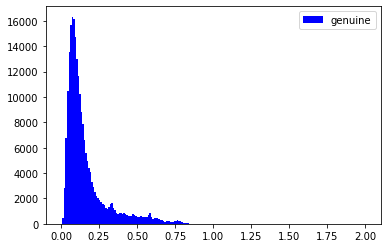

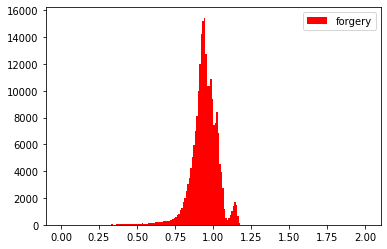

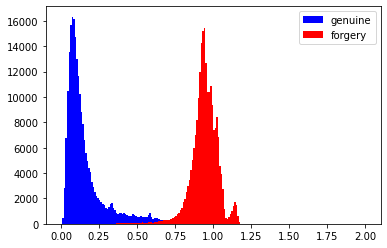

thresh		frr		far
-------------------------------------
0.0		0.0		100.0
5.0		0.0		100.0
10.0		0.0		100.0
15.0		0.0		100.0
20.0		0.0		100.0
25.0		0.0		100.0
30.0		0.0		94.76
35.0		0.0		38.5
40.0		0.17		4.22
45.0		1.41		1.21
50.0		2.65		0.75
55.0		4.46		0.47
60.0		6.28		0.31
65.0		8.43		0.2
70.0		11.56		0.11
75.0		15.72		0.07
80.0		22.96		0.03
85.0		40.61		0.02
90.0		80.76		0.0
95.0		100.0		0.0


In [19]:
draw_distributions(all_forgery_distances, all_genuine_distances)
print_report(all_forgery_distances, all_genuine_distances)